# WFSS Spectra Part 3: Emission Line Map

**Use case:** optimal extraction of grism spectra; redshift measurement; emission-line maps.  Simplified version of [JDox Science Use Case # 33](https://jwst-docs.stsci.edu/near-infrared-imager-and-slitless-spectrograph/niriss-example-science-programs/niriss-wfss-with-nircam-parallel-imaging-of-galaxies-in-lensing-clusters).<br>
**Data:** JWST simulated NIRISS images from [MIRAGE](https://jwst-docs.stsci.edu/jwst-other-tools/mirage-data-simulator), run through the [JWST calibration pipeline](https://jwst-pipeline.readthedocs.io/en/latest/); galaxy cluster.<br>
**Tools:**  specutils, astropy, pandas, emcee, lmfit, corner, h5py.<br>
**Cross-intrument:** NIRSpec <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>


## Introduction

This notebook is 4 of 4 in a set focusing on NIRISS WFSS data:
    1. 1D optimal extraction since the JWST pipeline only provides a box extraction.  Optimal extraction improves S/N of spectra for faint sources.
    2. Combine and normalize 1D spectra.
    3. Cross correlate galaxy with template to get redshift.
    4. Spatially resolved emission line map.

This notebook obtains an emission line map from the 2D-cutout of NIRISS WFSS spectra. This notebook will require the 2D-cutout of NIRISS WFSS spectrum (e.g., l3_nis_f150w_G150C_s00004_cal.fits; Pipeline spec3 product).

**Note:** For this example, the notebook uses only a 2D rectified spectra at one dither position, directly obtained from the current versionn of the  pipeline (Build 7.5), but one could start with spectra stacked with all dither positions too, to improve S/Ns.


In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np

from astropy.io import fits
import astropy.units as u
from astropy.modeling import models
from astropy.modeling.polynomial import Chebyshev1D

from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils.fitting import continuum

from astropy import __version__ as astropy_version
print('astropy', astropy_version)

astropy 6.1.4


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

### 0. Download notebook 01 products
These can be also obtained by running the notebooks.

In [4]:
if not os.path.exists('./output'):
    import zipfile
    import urllib.request
    boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/NIRISS_lensing_cluster/output.zip'
    boxfile = './output.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()
else:
    print('Already exists')

In [5]:
# Download files, if not exists yet.
if not os.path.exists('./pipeline_products'):
    import zipfile
    import urllib.request
    boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/NIRISS_lensing_cluster/pipeline_products.zip'
    boxfile = './pipeline_products.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()

In [6]:
# Which target?
DIR_OUT = './output/'
filt = 'f200w'

grism = 'G150C'
# grism = 'G150R'

id = '00004'

### 1.Get Halpha emission line map;

In [7]:
# Open two-dimensional file;
# can be downloaded in No.01a.
DIR_DATA = './pipeline_products/'

# Zero-indexed number for dither --- the test data has two dither positions.
ndither = 0

# File
file_2d = f'{DIR_DATA}l3_nis_{filt}_{grism}_s{id}_cal.fits'
hdu_2d = fits.open(file_2d)

# Align grism direction
#   - x-direction = Dispersion (wavelength) direction.
#   - y-direction = Cross-dispersion.
# in this notebook.
    
if grism == 'G150C':
    # If spectrum is horizontal;
    data_2d = hdu_2d[ndither*7+1].data
    dq_2d = hdu_2d[ndither*7+2].data
    err_2d = hdu_2d[ndither*7+3].data
    wave_2d = hdu_2d[ndither*7+4].data
else:
    data_2d = rotate(hdu_2d[ndither*7+1].data, 90)
    dq_2d = rotate(hdu_2d[ndither*7+2].data, 90)
    err_2d = rotate(hdu_2d[ndither*7+3].data, 90)
    wave_2d = rotate(hdu_2d[ndither*7+4].data, 90)

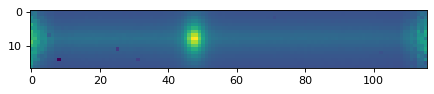

In [8]:
plt.imshow(data_2d[:, :])

### Subtract continuum at each y-position:
There are two options, depending on the brightness of the source;
- 1.Subtract continuum estimated at each position of cross-dispersion column. This works for a bright source.
- 2.Subtract a single continuum ("master continuum"), assuming the shape is same across cross-dispersion direction as the one from a 1d extraction. This is required for a faint source.

Since we clearly see continuum across the source, here we demonstrate the option 1.

(1.6, 2.3)

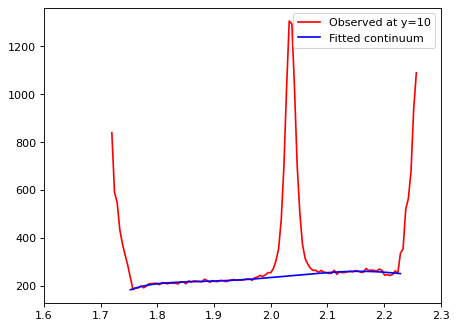

In [9]:
# At which y position do we want to see spectrum?
# as an example;
yy = 10

spec_unit = u.dimensionless_unscaled

mask_line = ((wave_2d[yy, :] > 1.75) & (wave_2d[yy, :] < 1.97)) | ((wave_2d[yy, :] > 2.08) & (wave_2d[yy, :] < 2.23))

obs = Spectrum1D(spectral_axis=wave_2d[yy, :][mask_line]*u.um, flux=data_2d[yy, :][mask_line]*spec_unit)
cont = continuum.fit_generic_continuum(obs, model=Chebyshev1D(7))

plt.plot(wave_2d[yy, :], data_2d[yy, :], color='r', label=f'Observed at y={yy}')
plt.plot(wave_2d[yy, :][mask_line]*u.um, cont(wave_2d[yy, :][mask_line]*u.um), color='b', label='Fitted continuum')

plt.legend(loc=0)
plt.xlim(1.6, 2.3)

In [10]:
cont(wave_2d[yy, :][mask_line]*u.um).value

array([250.33514357, 251.34196958, 252.33995488, 253.31373444,
       254.24980289, 255.1366691 , 255.96455747, 256.72516346,
       257.4117817 , 258.0190447 , 258.54273033, 258.97986591,
       259.32840484, 259.58730322, 259.7563374 , 259.83601394,
       259.82753626, 259.73268184, 259.55376828, 259.293551  ,
       258.95515925, 258.54210302, 258.05809107, 257.50714692,
       256.89339292, 256.22107255, 255.4946222 , 254.718431  ,
       253.89689776, 253.03453603, 252.13569829, 251.20466554,
       227.29370341, 226.56797823, 225.86951584, 225.19837713,
       224.55451483, 223.93770379, 223.34764272, 222.78388336,
       222.24585256, 221.73279539, 221.24384815, 220.7779837 ,
       220.33396628, 219.91040966, 219.50570878, 219.11804706,
       218.74533173, 218.38522929, 218.03510728, 217.6919781 ,
       217.35251746, 217.01299429, 216.66924512, 216.31659606,
       215.94986802, 215.56329906, 215.15045854, 214.70424682,
       214.21679175, 213.67940417, 213.08245036, 212.41

In [11]:
# Repeat this along y-axis;
flux_cont2d = data_2d[:, :] * 0
for yy in range(len(data_2d[:, 0])):

    mask_line = ((wave_2d[yy, :] > 1.75) & (wave_2d[yy, :] < 1.97)) | ((wave_2d[yy, :] > 2.08) & (wave_2d[yy, :] < 2.23))

    obs = Spectrum1D(spectral_axis=wave_2d[yy, :][mask_line]*u.um, flux=data_2d[yy, :][mask_line]*spec_unit)
    cont = continuum.fit_generic_continuum(obs, model=Chebyshev1D(7))

    flux_cont2d[yy, :] = cont(wave_2d[yy, :]*u.um).value

Text(0.5, 1.0, 'Fitted continuum')

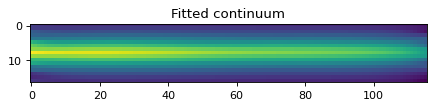

In [12]:
plt.imshow(flux_cont2d[:, :])
plt.title('Fitted continuum')

Text(0.5, 1.0, 'Continuum subtracted spectrum')

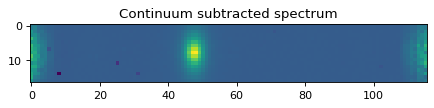

In [13]:
plt.imshow(data_2d[:, :] - flux_cont2d[:, :])
plt.title('Continuum subtracted spectrum')

### Extract Halpha emission from a continuum-subtracted spectrum;

Text(0.5, 1.0, 'H$\\alpha$ map')

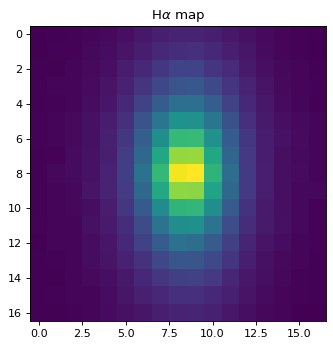

In [14]:
# Cutout Ha line map;
rsq = data_2d.shape[0]
cut_ha = np.zeros((rsq, rsq), 'float32')

zin = 2.1 # From Notebook No.3, cross-correlation;
lamcen = 0.6564 * (1. + zin)

for yy in range(len(data_2d[:, 0])):
    # This has to be done at each y pixel, as wavelength array can be tilted.
    index_lamcen = np.argmin(np.abs(lamcen - wave_2d[yy, :]))
    cut_ha[yy, :] = (data_2d - flux_cont2d)[yy, int(index_lamcen-rsq/2.):int(index_lamcen+rsq/2.)]

plt.imshow(cut_ha)
plt.title('H$\\alpha$ map')

### 2.Get Hbeta and OIII maps
This is more challenging, as these lines locate close to each other. Ideally, iteration process will be preferred, but here we use Specutils' double gaussian component fitting, in a similar way for Ha.

Text(0.5, 1.0, 'f150w')

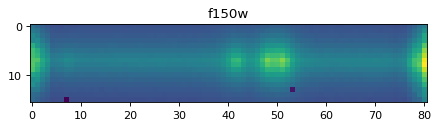

In [15]:
filt = 'f150w'

file_2d = f'{DIR_DATA}l3_nis_{filt}_{grism}_s{id}_cal.fits'
hdu_2d = fits.open(file_2d)

# Align grism direction
#   - x-direction = Dispersion (wavelength) direction.
#   - y-direction = Cross-dispersion.
# in this notebook.
    
if grism == 'G150C':
    # If spectrum is horizontal;
    data_2d = hdu_2d[ndither*7+1].data
    dq_2d = hdu_2d[ndither*7+2].data
    err_2d = hdu_2d[ndither*7+3].data
    wave_2d = hdu_2d[ndither*7+4].data
else:
    data_2d = rotate(hdu_2d[ndither*7+1].data, 90)
    dq_2d = rotate(hdu_2d[ndither*7+2].data, 90)
    err_2d = rotate(hdu_2d[ndither*7+3].data, 90)
    wave_2d = rotate(hdu_2d[ndither*7+4].data, 90)
    
# !! Note that the extracted spectra has flipped wavelength direction !!
plt.imshow(data_2d[:, ::-1])
plt.title(f'{filt}')

### In the plot above, you can see Oiii doublet, and Hbeta. 

#### 2a. Get continuum;

(1.2, 1.8)

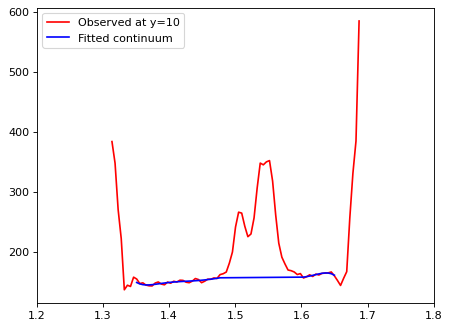

In [16]:
yy = 10 # as an example;

spec_unit = u.dimensionless_unscaled

mask_line = ((wave_2d[yy, :] > 1.35) & (wave_2d[yy, :] < 1.48)) | ((wave_2d[yy, :] > 1.6) & (wave_2d[yy, :] < 1.65))

obs = Spectrum1D(spectral_axis=wave_2d[yy, :][mask_line]*u.um, flux=data_2d[yy, :][mask_line]*spec_unit)
cont = continuum.fit_generic_continuum(obs, model=Chebyshev1D(7))

plt.plot(wave_2d[yy, :], data_2d[yy, :], color='r', label=f'Observed at y={yy}')

plt.plot(wave_2d[yy, :][mask_line]*u.um, cont(wave_2d[yy, :][mask_line]*u.um), color='b', label='Fitted continuum')

plt.legend(loc=0)
plt.xlim(1.2, 1.8)

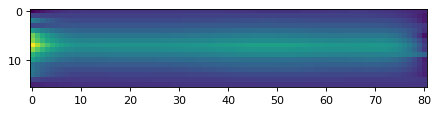

In [17]:
# Repeat this along y-axis;
flux_cont2d_150 = data_2d[:, :] * 0
for yy in range(len(data_2d[:, 0])):

    mask_line = ((wave_2d[yy, :] > 1.35) & (wave_2d[yy, :] < 1.48)) | ((wave_2d[yy, :] > 1.6) & (wave_2d[yy, :] < 1.65))

    obs = Spectrum1D(spectral_axis=wave_2d[yy, :][mask_line]*u.um, flux=data_2d[yy, :][mask_line]*spec_unit)
    cont = continuum.fit_generic_continuum(obs, model=Chebyshev1D(7))

    flux_cont2d_150[yy, :] = cont(wave_2d[yy, :]*u.um).value

plt.imshow(flux_cont2d_150[:, ::-1])

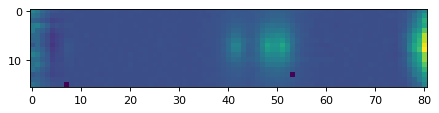

In [18]:
line_2d = data_2d[:, :] - flux_cont2d_150[:, :]

plt.imshow(line_2d[:, ::-1])

#### 2b. Fit emissionn, with multi-conponent gaussian;

In [19]:
yy = 10

# Fit the spectrum
con = (1.4 < wave_2d[yy, :]) & (wave_2d[yy, :] < 1.65)

spectrum_cut = Spectrum1D(flux=line_2d[yy, :][con]*spec_unit,
                          spectral_axis=wave_2d[yy, :][con]*u.um)

# !!! Some tweaks may be needed for initial value, to successfully run the fit;

# For Hb
g1_init = models.Gaussian1D(amplitude=100*spec_unit, mean=1.51*u.um, stddev=0.009*u.um)

# For O3 blue
g2_init = models.Gaussian1D(amplitude=80.*spec_unit, mean=1.53*u.um, stddev=0.006*u.um)

# For O3 red
g3_init = models.Gaussian1D(amplitude=200.*spec_unit, mean=1.55*u.um, stddev=0.006*u.um)

g123_fit = fit_lines(spectrum_cut, g1_init+g2_init+g3_init)
y_fit = g123_fit(wave_2d[yy, :]*u.um)

print(g123_fit)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Gaussian1D(amplitude=105.66876572 , mean=1.50774475 um, stddev=0.00935791 um)>

    [1]: <Gaussian1D(amplitude=81.51774077 , mean=1.53394139 um, stddev=0.00642775 um)>

    [2]: <Gaussian1D(amplitude=186.63437024 , mean=1.54934874 um, stddev=0.0111155 um)>
Parameters:
       amplitude_0           mean_0       ...       stddev_2      
                               um         ...          um         
    ------------------ ------------------ ... --------------------
    105.66876571858835 1.5077447499079528 ... 0.011115499764483106


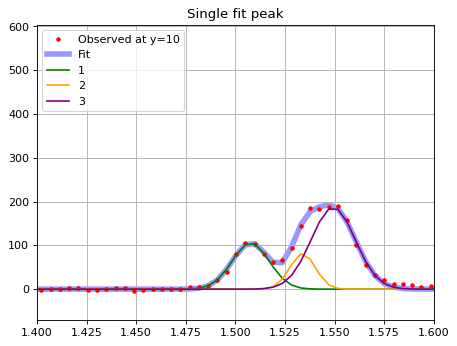

In [20]:
# Plot separately?
plt.plot(wave_2d[yy, :], line_2d[yy, :], marker='.', ls='', color='r', label=f'Observed at y={yy}')
plt.plot(wave_2d[yy, :], y_fit, color='b', label='Fit', zorder=-2, alpha=0.4, lw=5)

y_fit1 = g123_fit[0](wave_2d[yy, :]*u.um)
plt.plot(wave_2d[yy, :], y_fit1, color='g', label='1')

y_fit1 = g123_fit[1](wave_2d[yy, :]*u.um)
plt.plot(wave_2d[yy, :], y_fit1, color='orange', label='2')

y_fit1 = g123_fit[2](wave_2d[yy, :]*u.um)
plt.plot(wave_2d[yy, :], y_fit1, color='purple', label='3')

plt.xlim(1.4, 1.6)

plt.title('Single fit peak')
plt.grid(True)
plt.legend(loc=2)

In [21]:
print(g123_fit[0])
print(g123_fit[1])
print(g123_fit[2])

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev       
                               um                  um         
    ------------------ ------------------ --------------------
    105.66876571858835 1.5077447499079528 0.009357907153986163
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev       
                              um                 um         
    ----------------- ----------------- --------------------
    81.51774076684723 1.533941390030872 0.006427752630558015
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean               stddev       
                              um                  um         
    ----------------- ------------------ --------------------
    186.6343702431592 1.5493487398640626 0.011115499764483106


### Fit to the central array looks good. Repeat this along y-axis and get emission line maps, as a same way as for Halpha

In [22]:
# Cutout Hb, Oiii line maps;
rsq = data_2d.shape[0]
cut_hb = np.zeros((rsq, rsq), 'float32')
cut_o3b = np.zeros((rsq, rsq), 'float32')
cut_o3r = np.zeros((rsq, rsq), 'float32')

zin = 2.1 # Redshift estimate from Notebook No.2, cross-correlation;
lamcen_hb = 0.4862680 * (1. + zin)
lamcen_o3b = 0.4960295 * (1. + zin)
lamcen_o3r = 0.5008240 * (1. + zin)

for yy in range(len(data_2d[:, 0])):
    # Fit the spectrum
    con = (1.4 < wave_2d[yy, :]) & (wave_2d[yy, :] < 1.65)
    spectrum_cut = Spectrum1D(flux=line_2d[yy, :][con]*spec_unit, 
                              spectral_axis=wave_2d[yy, :][con]*u.um)

    # !!! Some tweaks may be needed for initial value, to successfuully run the fit;

    # For Hb
    g1_init = models.Gaussian1D(amplitude=100*spec_unit, mean=1.51*u.um, stddev=0.009*u.um)
    # For O3 blue
    g2_init = models.Gaussian1D(amplitude=80.*spec_unit, mean=1.53*u.um, stddev=0.006*u.um)
    # For O3 red
    g3_init = models.Gaussian1D(amplitude=200.*spec_unit, mean=1.55*u.um, stddev=0.006*u.um)
    g123_fit = fit_lines(spectrum_cut, g1_init+g2_init+g3_init)
    y_fit = g123_fit(wave_2d[yy, :]*u.um)

    # This has to be done at each y pixel, as wavelength array can be tilted.
    index_lamcen_hb = np.argmin(np.abs(lamcen_hb - wave_2d[yy, :]))
    cut_hb[yy, :] = g123_fit[0](wave_2d[yy, :]*u.um)[int(index_lamcen_hb-rsq/2.):int(index_lamcen_hb+rsq/2.)]

    index_lamcen_o3b = np.argmin(np.abs(lamcen_o3b - wave_2d[yy, :]))
    cut_o3b[yy, :] = g123_fit[1](wave_2d[yy, :]*u.um)[int(index_lamcen_o3b-rsq/2.):int(index_lamcen_o3b+rsq/2.)]

    index_lamcen_o3r = np.argmin(np.abs(lamcen_o3r - wave_2d[yy, :]))
    cut_o3r[yy, :] = g123_fit[2](wave_2d[yy, :]*u.um)[int(index_lamcen_o3r-rsq/2.):int(index_lamcen_o3r+rsq/2.)]

Text(0.5, 1.0, 'H$\\beta$ map')

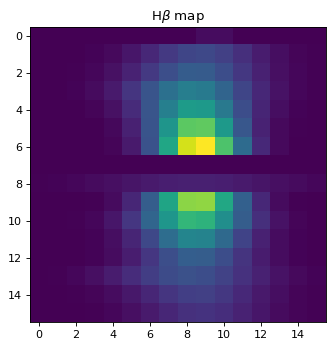

In [23]:
plt.imshow(cut_hb)
plt.title('H$\\beta$ map')

Text(0.5, 1.0, 'Oiii 4960')

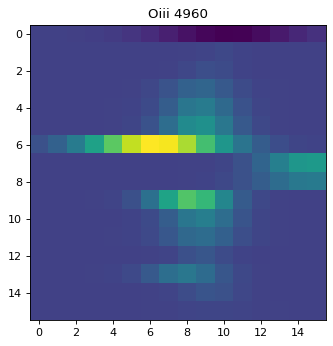

In [24]:
plt.imshow(cut_o3b)
plt.title('Oiii 4960')

Text(0.5, 1.0, 'Oiii 5008')

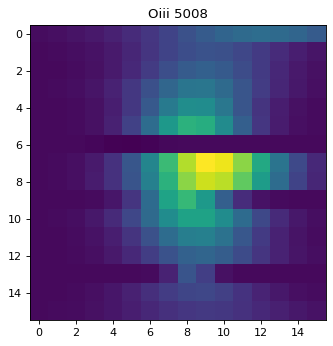

In [25]:
plt.imshow(cut_o3r)
plt.title('Oiii 5008')

## Summary;
As seen above, regions except for the very center <font color='red'>do not look right.</font> This is due to failure of multi-component fit, especially for Oiii doublet.
To improve the fit, one can either;
- fit and inspect the fit repeatedly at each y-axis until it converges,
- use MCMC for more intensive fitting, which also enables to fix the ratio of two Oiii lines by setting up a prior.
- or reduce the number of components, especially for Oiii doublet at the edge of the source position, where the lines are blended.